# Enumerating minimal sets of metabolite exchanges in a host-microbe model of the human gut

This notebook performs the analysis of metabolite exchanges in the human gut presented in our paper:

O. Øyås et al. "Scalable metabolic pathway analysis" (2022).

In [4]:
import cobra
import gurobipy as grb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict, OrderedDict
from importlib import reload
from itertools import combinations, product, chain
from os.path import join
from scipy.stats import f_oneway

from mptool import *

%matplotlib inline
results_dir = 'results'


Bad key text.latex.preview in file c:\users\ovoy\envs\mptool\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\users\ovoy\envs\mptool\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\users\ovoy\envs\mptool\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You pr

## Load and prepare human and microbe models

In [99]:
models = OrderedDict()

# Load human model
models['HS'] = cobra.io.load_matlab_model('models/Recon3D_301/Recon3DModel_301.mat')

# Load microbe models
microbe_dir = 'models/AGORA-1.03-With-Mucins/reconstructions/sbml/'
microbe_ids = {
    'BT': 'Bacteroides_thetaiotaomicron_VPI_5482',
    'EC': 'Escherichia_coli_str_K_12_substr_MG1655',
    'FP': 'Faecalibacterium_prausnitzii_A2_165',
    'LL': 'Lactococcus_lactis_subsp_lactis_Il1403',
    'LP': 'Lactobacillus_plantarum_WCFS1',
    'ST': 'Streptococcus_thermophilus_LMG_18311'
}
models.update({k: cobra.io.read_sbml_model(microbe_dir + v + '.xml') for k, v in microbe_ids.items()})

models

OrderedDict([('HS', <Model Recon3DModel at 0x1d4044732b0>),
             ('BT',
              <Model Bacteroides_thetaiotaomicron_VPI_5482 at 0x1d404473550>),
             ('EC',
              <Model Escherichia_coli_str_K_12_substr_MG1655 at 0x1d3dce8a1d0>),
             ('FP',
              <Model Faecalibacterium_prausnitzii_A2_165 at 0x1d3e6953ac8>),
             ('LL',
              <Model Lactococcus_lactis_subsp_lactis_Il1403 at 0x1d3e51b3e10>),
             ('LP', <Model Lactobacillus_plantarum_WCFS1 at 0x1d3dba61198>),
             ('ST',
              <Model Streptococcus_thermophilus_LMG_18311 at 0x1d3e0d24f60>)])

In [100]:
# Check number of reactions and metabolites
for k, m in models.items():
    print(k)
    print(len(m.reactions), len(m.metabolites))

HS
10600 5835
BT
2524 1549
EC
2313 1625
FP
1225 1047
LL
1295 1118
LP
1753 1348
ST
954 851


In [101]:
# Model preprocessing

tol = 1e-6

for k, m in models.items():
    print(k)
    
    # Make all exchanges reversible and turn off oxygen exchange for microbes
    for r in m.exchanges:
        if k != 'HS' and r.id.startswith('EX_o2'):
            r.bounds = 0, 0
            print(r.id, r.bounds)
        else:
            r.bounds = -1000, 1000
        
#     # Make sinks and demands irreversible
#     for r in m.sinks:
#         r.upper_bound = 0
#     for r in m.demands:
#         r.lower_bound = 0

    # Turn off non-essential sinks and demands
    sd = list(chain(m.sinks, m.demands))
    if k == 'HS':
        ne = sd
    else:
        df = cobra.flux_analysis.single_reaction_deletion(m, reaction_list=sd)
        ne = set(m.reactions.get_by_id(next(iter(x))) for x in df[df.growth.abs() > tol].index)
    for r in ne:
        r.bounds = 0, 0
        
    # Get biomass reactions and sort by number of reactants
    bm = [(r, len(r.reactants)) for r in m.reactions if not r.boundary and 'biomass' in r.id.lower()]
    bm.sort(key=lambda x: x[1])
    
    # Set biomass reaction with largest number of reactants as objective and remove any others
    r = bm.pop()[0]
    m.objective = r
    if bm:
        m.remove_reactions([r for r, x in bm], remove_orphans=True)
    
    # Maximize growth rate
    print(m.optimize().objective_value)
    
    # Set growth requirements
    if k == 'HS':
        r.bounds = 0, 0
    else:
        r.bounds = 0.1, 0.1
    print(r.id, r.bounds)
        
    # Set non-growth-associated maintenance requirements
    r = m.reactions.DM_atp_c_
    if k == 'HS':
        r.bounds = 0.1, 0.1
    else:
        r.bounds = 0, 0
    print(r.id, r.bounds)
    
    # Check feasibility
    print(m.optimize().status)
    
    # Prefix metabolites, reactions, and genes with organism ID
    for x in chain(m.metabolites, m.reactions, m.genes):
        x.id = k + '_' + x.id
    m.repair()
    
    print()

HS
629.5148624342959
biomass_reaction (0, 0)
DM_atp_c_ (0.1, 0.1)
optimal

BT
EX_o2(e) (0, 0)
104.3036821280584
biomass345 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal

EC
EX_o2(e) (0, 0)
139.70929909838847
biomass525 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal

FP
EX_o2(e) (0, 0)
67.87688311135571
biomass223 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal

LL
EX_o2(e) (0, 0)
66.40796490162879
biomass065 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal

LP
EX_o2(e) (0, 0)
74.24924162779239
biomass524 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal

ST
EX_o2(e) (0, 0)
63.46986813735304
biomass525 (0.1, 0.1)
DM_atp_c_ (0, 0)
optimal



## Build host-microbe model

In [102]:
# Create host-microbe model
hm = cobra.Model('_'.join(models.keys()))
hm.compartments = {
    'c': 'cytosol',
    'l': 'lysosome',
    'm': 'mitochondria',
    'r': 'endoplasmic reticulum',
    'e': 'extracellular space',
    'x': 'peroxisome/glyoxysome',
    'n': 'nucleus',
    'g': 'golgi apparatus',
    'i': 'inner mitochondrial compartment'
}

# Add models to host-microbe model
for k, m in models.items():
    hm.merge(m)
hm

# Check feasibility
hm.optimize()

<Solution 0.000 at 0x1d40def2470>

In [103]:
# Add shared compartment
hm.compartments.update({'s': 'shared'})

# Get external exchanges
x = defaultdict(list)
for r in hm.exchanges:
    try:
        m = r.reactants[0]
    except IndexError:
        continue 
    x[m.id[3:-3]].append(m.id[:2])

# Add exchanges through shared compartment
new = []
skip = set(['arab', 'atp', 'biomass', 'ca2', 'cd2', 'cl', 'co2', 'cobalt2', 'cu', 'cu2', 'fe2', 'fe3', 'fru', 'gal', 'glc_D',
            'h', 'h2', 'h2o','h2o2', 'h2s', 'hg2', 'k', 'malt', 'malttr', 'man', 'mg2', 'mn1', 'mn2', 'na1', 'nh4', 'no', 'no2', 'no3',
            'o2', 'o2s', 'pi', 'ppi', 'so4', 'xyl_D', 'zn2'])

for m_id, l in x.items():
    if m_id in skip:
        continue

    if len(l) > 1:
        m1 = cobra.Metabolite(m_id + '[s]')
        m1.compartment = 's'

        for k in l:
            m2 = hm.metabolites.get_by_id(k + '_' + m_id + '[e]')
            iex = cobra.Reaction('_'.join([k, 'IEX', m_id]))
            iex.add_metabolites({m1: 1, m2: -1})
            if k == 'HS':
                iex.bounds = -1000, 0
            else:
                iex.bounds = -1000, 1000
            new.append(iex)
hm.add_reactions(new)
print(len(new))

# Check feasibility
hm.optimize()

1681


<Solution 0.000 at 0x1d406da4d30>

In [104]:
# Make host-microbe model irreversible
print(len(hm.reactions))
make_irreversible(hm)
print(len(hm.reactions))

22343
33296


## Solve and constrain host-microbe model

In [116]:
# Create Gurobi model
model = create_lp(hm)
model.setParam('OutputFlag', True)
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
# model.setParam('NumericFocus', 3)

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OptimalityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter FeasibilityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06


In [107]:
# Fractional deviation from minima allowed 
alpha = 0

In [108]:
# Minimize internal microbial fluxes
inr = [v for v in model.getVars()
       if model.getCol(v).size() > 1 and not ('IEX' in v.varName or v.varName.startswith('HS_'))]
model.setObjective(grb.LinExpr(np.ones(len(inr)), inr))
model.ModelSense = 1
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', True)
model.optimize()

Parameter OptimalityTol unchanged
   Value: 1e-09  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter FeasibilityTol unchanged
   Value: 1e-09  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 13862 rows, 33296 columns and 111194 nonzeros
Model fingerprint: 0xfcefc142
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e+03]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 8627 rows and 20252 columns
Presolve time: 0.12s
Presolved: 5235 rows, 13044 columns, 53758 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.350e+04
 Factor NZ  : 2.625e+05 (roughly 10 MBytes of memory)
 Factor Ops : 4.370e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective               

In [109]:
# Constrain internal microbial fluxes to value in minimum (note that minimum is not unique)
for v in inr:
    v.lb = v.ub = v.x
    print(v.varName, v.x)
model.update()

BT_12PPDt 0.0
BT_23DHMPO 0.0
BT_23PDE2 0.0
BT_23PDE4 0.0
BT_23PDE7 0.0
BT_23PDE9 0.0
BT_26DAPLLAT 0.0
BT_2AHBUTI 0.0
BT_2MBCOATA 0.0085184
BT_2MMALD 0.0
BT_2MMALD2 0.0
BT_2OBUTt2r 0.0326984
BT_3HACPR1 0.0
BT_3HACPR2 0.0
BT_3HAD100 0.0
BT_3HAD10M11 0.0
BT_3HAD10M12 0.0085184
BT_3HAD11M12 0.0085184
BT_3HAD120 0.0
BT_3HAD12M13 0.0
BT_3HAD12M14 0.0085184
BT_3HAD13M14 0.0085184
BT_3HAD140 0.0
BT_3HAD14M15 0.0
BT_3HAD14M16 0.0085184
BT_3HAD15M16 0.0085184
BT_3HAD160 0.0
BT_3HAD180 0.0
BT_3HAD40 0.0
BT_3HAD4M5 0.0
BT_3HAD4M6 0.0085184
BT_3HAD5M6 0.0085184
BT_3HAD60 0.0
BT_3HAD6M7 0.0
BT_3HAD6M8 0.0085184
BT_3HAD7M8 0.0085184
BT_3HAD80 0.0
BT_3HAD8M10 0.0085184
BT_3HAD8M9 0.0
BT_3HAD9M10 0.0085184
BT_3MOBS 0.0
BT_3OAACPR1 0.0
BT_3OAACPR2 0.0
BT_3OAR100 0.0
BT_3OAR10M11 0.0
BT_3OAR10M12 0.0085184
BT_3OAR11M12 0.0085184
BT_3OAR120 0.0
BT_3OAR12M13 0.0
BT_3OAR12M14 0.0085184
BT_3OAR13M14 0.0085184
BT_3OAR140 0.0100044
BT_3OAR14M15 0.0
BT_3OAR14M16 0.0085184
BT_3OAR15M16 0.0085184
BT_3OAR160 0.0
B

BT_BGALASE_OGLYCAN30e 0.0
BT_BGALASE_OGLYCAN31e 0.0
BT_BGALASE_OGLYCAN32e 0.0
BT_BGALASE_OGLYCAN33e 0.0
BT_BGALASE_OGLYCAN34e 0.0
BT_BGALASE_OGLYCAN35e 0.0
BT_BGALASE_OGLYCAN36e 0.0
BT_BGALASE_OGLYCAN37e 0.0
BT_BGALASE_OGLYCAN38e 0.0
BT_BGALASE_OGLYCAN39e 0.0
BT_BGALASE_OGLYCAN3e 0.0
BT_BGALASE_OGLYCAN40e 0.0
BT_BGALASE_OGLYCAN41e 0.0
BT_BGALASE_OGLYCAN42e 0.0
BT_BGALASE_OGLYCAN43e 0.0
BT_BGALASE_OGLYCAN44e 0.0
BT_BGALASE_OGLYCAN45e 0.0
BT_BGALASE_OGLYCAN46e 0.0
BT_BGALASE_OGLYCAN47e 0.0
BT_BGALASE_OGLYCAN48e 0.0
BT_BGALASE_OGLYCAN49e 0.0
BT_BGALASE_OGLYCAN4e 0.0
BT_BGALASE_OGLYCAN50e 0.0
BT_BGALASE_OGLYCAN51e 0.0
BT_BGALASE_OGLYCAN52e 0.0
BT_BGALASE_OGLYCAN53e 0.0
BT_BGALASE_OGLYCAN54e 0.0
BT_BGALASE_OGLYCAN55e 0.0
BT_BGALASE_OGLYCAN56e 0.0
BT_BGALASE_OGLYCAN57e 0.0
BT_BGALASE_OGLYCAN58e 0.0
BT_BGALASE_OGLYCAN59e 0.0
BT_BGALASE_OGLYCAN5e 0.0
BT_BGALASE_OGLYCAN60e 0.0
BT_BGALASE_OGLYCAN61e 0.0
BT_BGALASE_OGLYCAN62e 0.0
BT_BGALASE_OGLYCAN63e 0.0
BT_BGALASE_OGLYCAN64e 0.0
BT_BGALASE_OGLY

BT_FT 0.0025011
BT_FTCD 0.0
BT_FTHFCL 0.0
BT_FTHFD 0.0
BT_FTHFL 0.0
BT_FUCASE_OGLYCAN100e 0.0
BT_FUCASE_OGLYCAN101e 0.0
BT_FUCASE_OGLYCAN102e 0.0
BT_FUCASE_OGLYCAN103e 0.0
BT_FUCASE_OGLYCAN104e 0.0
BT_FUCASE_OGLYCAN105e 0.0
BT_FUCASE_OGLYCAN106e 0.0
BT_FUCASE_OGLYCAN107e 0.0
BT_FUCASE_OGLYCAN108e 0.0
BT_FUCASE_OGLYCAN109e 0.0
BT_FUCASE_OGLYCAN10e 0.0
BT_FUCASE_OGLYCAN110e 0.0
BT_FUCASE_OGLYCAN111e 0.0
BT_FUCASE_OGLYCAN112e 0.0
BT_FUCASE_OGLYCAN113e 0.0
BT_FUCASE_OGLYCAN114e 0.0
BT_FUCASE_OGLYCAN115e 0.0
BT_FUCASE_OGLYCAN116e 0.0
BT_FUCASE_OGLYCAN117e 0.0
BT_FUCASE_OGLYCAN118e 0.0
BT_FUCASE_OGLYCAN119e 0.0
BT_FUCASE_OGLYCAN11e 0.0
BT_FUCASE_OGLYCAN120e 0.0
BT_FUCASE_OGLYCAN121e 0.0
BT_FUCASE_OGLYCAN122e 0.0
BT_FUCASE_OGLYCAN123e 0.0
BT_FUCASE_OGLYCAN124e 0.0
BT_FUCASE_OGLYCAN125e 0.0
BT_FUCASE_OGLYCAN126e 0.0
BT_FUCASE_OGLYCAN127e 0.0
BT_FUCASE_OGLYCAN128e 0.0
BT_FUCASE_OGLYCAN129e 0.0
BT_FUCASE_OGLYCAN12e 0.0
BT_FUCASE_OGLYCAN130e 0.0
BT_FUCASE_OGLYCAN131e 0.0
BT_FUCASE_OGLYCAN132e 0.0

BT_METAT 0.0012386
BT_METFR 0.009223349999999936
BT_METS 0.014018599999999999
BT_METSOXR1r 0.0
BT_MG2abc 0.0
BT_MGSA 0.0
BT_MGt5 0.0
BT_MI1PI 0.0
BT_MI1PP 0.0
BT_MI3PP 0.0
BT_MI4PP 0.0
BT_MLTG1 0.0
BT_MMCD 0.0
BT_MME 0.0
BT_MMM2r 0.0
BT_MNNH 0.0
BT_MNt2 0.00030965
BT_MOAT 0.0025011
BT_MOAT3C 0.0025011
BT_MOHMT 0.0006192999999999893
BT_MTAN 0.0
BT_MTHFC 0.008545700000000002
BT_MTHFD 0.008545700000000002
BT_NACHEX27e 0.0
BT_NACt2r 0.0
BT_NADH10 0.0
BT_NADH5 0.0
BT_NADH6 4.056794976083476
BT_NADH9 0.0
BT_NADK 0.00030965000000005016
BT_NADK2 0.0
BT_NADS1 0.0
BT_NADS2 0.0006193000000000448
BT_NAPRT 0.0009289500000000449
BT_NAt3 0.0
BT_NAt3_1 0.0818692
BT_NCPTRCA 0.00030965
BT_NDPK1 0.01731065
BT_NDPK2 0.0190876
BT_NDPK3 0.0611578
BT_NDPK4 0.0041032
BT_NDPK5 0.0
BT_NDPK6 0.0
BT_NDPK7 0.0016021000000000002
BT_NDPK8 0.0
BT_NDPK9 0.0
BT_NH4t4 0.0
BT_NH4tb 0.0
BT_NNATr 0.0006193000000000448
BT_NNDMBRT 0.00030965
BT_NNDPR 0.0
BT_NO2rPmq 1.3868266420278255
BT_NP1_r 0.0
BT_NPHS 0.0006193
BT_NT5C 0.

BT_TECA1S140 0.0
BT_TECA1S160 0.0
BT_TECA1S180 0.0
BT_TECA1SAI15 0.0
BT_TECA1SAI17 0.0
BT_TECA1SI14 0.0
BT_TECA1SI15 0.0
BT_TECA1SI16 0.0
BT_TECA1SI17 0.0
BT_TECA5S140 0.0
BT_TECA5S160 0.0
BT_TECA5S180 0.0
BT_TECA5SAI15 0.0
BT_TECA5SAI17 0.0
BT_TECA5SI14 0.0
BT_TECA5SI15 0.0
BT_TECA5SI16 0.0
BT_TECA5SI17 0.0
BT_TEICH45 0.0
BT_TGBPA 0.0
BT_THIORDXi 0.0
BT_THMDt2r 0.0016021000000000004
BT_THRAi 0.0
BT_THRD 0.030280600000000015
BT_THRD_L 0.0
BT_THRS 0.0
BT_THRt2r 0.05138760000000002
BT_THZPSN 0.0003096500000000016
BT_TKT1 0.01196515
BT_TKT2 0.0
BT_TMDK1 0.0016021000000000004
BT_TMDPK 0.0
BT_TMDS 0.0
BT_TMPK 0.0003096500000000016
BT_TMPPP 0.0003096500000000016
BT_TPI 0.3216999084269649
BT_TRDOXOX 0.0
BT_TRDRr 0.0032042000000000004
BT_TREH 0.0
BT_TREabc 0.0
BT_TRPAS2i 0.0
BT_TRPS1 0.0
BT_TRPS2 0.0
BT_TRPS3 0.0
BT_TRPTA 0.0
BT_TRPt2r 0.004720200000000001
BT_TRSARr 0.0
BT_TTDCAtr 0.0025011
BT_TYRL 0.0
BT_TYRTA 0.0
BT_U23GAAT 0.0050022
BT_UAAGDS 0.0025011
BT_UAG2E 0.0
BT_UAG2EMA 0.0
BT_UAG4E 0

EC_AOXSr 0.0
EC_AOXSr2 0.0
EC_AP4AH 0.0
EC_APRAUR 0.00156188
EC_APSRmq 0.0
EC_APTNAT 0.0
EC_ARAI 0.0
EC_ARBTpts 0.0
EC_ARBabc 0.0
EC_ARBt2r 0.0
EC_ARGDC 0.0
EC_ARGSL 0.0
EC_ARGSSr 0.0
EC_ARGabc 0.0
EC_ARGt2 0.028827000000000005
EC_ASAD 0.0
EC_ASCBPL 0.0
EC_ASNS1 0.0
EC_ASNS2 0.0
EC_ASNt2r 0.023468000000000003
EC_ASO3t 0.0
EC_ASO4t 0.0
EC_ASP1DC 0.0
EC_ASPCT 0.0
EC_ASPKi 0.0092476
EC_ASPO1 0.0
EC_ASPO5 0.0
EC_ASPO6 0.0
EC_ASPO7 0.0
EC_ASPT 0.0
EC_ASPTA 0.008073559999998696
EC_ASPabc 0.0
EC_ASPt2 0.0407891599999987
EC_ASPt2_3 0.0
EC_AST 0.0
EC_ATPPRT 0.0
EC_ATPS4 2.773747279999995
EC_BACCLi 0.0
EC_BBTCOAOX 0.0
EC_BDH 0.0
EC_BETALDHx 0.0
EC_BETALDHy 0.0
EC_BGALASE_OGLYCAN100e 0.0
EC_BGALASE_OGLYCAN101e 0.0
EC_BGALASE_OGLYCAN102e 0.0
EC_BGALASE_OGLYCAN103e 0.0
EC_BGALASE_OGLYCAN104e 0.0
EC_BGALASE_OGLYCAN105e 0.0
EC_BGALASE_OGLYCAN106e 0.0
EC_BGALASE_OGLYCAN107e 0.0
EC_BGALASE_OGLYCAN108e 0.0
EC_BGALASE_OGLYCAN109e 0.0
EC_BGALASE_OGLYCAN10e 0.0
EC_BGALASE_OGLYCAN110e 0.0
EC_BGALASE_OGLYCAN

EC_GALASE_OGLYCAN3e 0.0
EC_GALCTD 0.0
EC_GALCTND 0.0
EC_GALCTNt2r 0.0
EC_GALK 0.0
EC_GALM1r 0.0
EC_GALS3 0.0
EC_GALT 0.0
EC_GALT1 0.0
EC_GALTpts 0.0
EC_GALU 0.0
EC_GALURt2r 0.0
EC_GALabc 0.0
EC_GALt2_2 0.0
EC_GAPD 0.5793354400000066
EC_GARFTi 0.0
EC_GART 0.0
EC_GBBTNt 0.0
EC_GCALDDr 0.0
EC_GCALDt 0.0
EC_GCCa 0.0
EC_GCCb 0.0
EC_GCCc 0.0
EC_GF6PTA 0.0
EC_GFUCS 0.0
EC_GGGABADr 0.0
EC_GGGABARr 0.0
EC_GGTA 0.0
EC_GGTT 0.0
EC_GHMT2r 0.0
EC_GK1 0.023646580000000004
EC_GK2 0.0
EC_GLCDe 0.0
EC_GLCNOXy 0.0
EC_GLCNt2r 0.0
EC_GLCOAS 0.0
EC_GLCP3 0.0
EC_GLCRAL 0.0
EC_GLCRD 0.0
EC_GLCRHL 0.0
EC_GLCRt2 0.0
EC_GLCS3 0.0
EC_GLCTR1 0.0
EC_GLCTR2 0.0
EC_GLCURt2r 0.0
EC_GLCabc 0.0
EC_GLCpts 0.0
EC_GLGC 0.0
EC_GLNS 0.0
EC_GLNSP1 0.0
EC_GLNSP2 0.0
EC_GLNSP3 0.0
EC_GLNabc 0.0
EC_GLTPD 0.0
EC_GLU5K 0.0
EC_GLUABUTt7 0.0
EC_GLUCYS 0.0
EC_GLUDC 0.0
EC_GLUDy 0.0
EC_GLUN 0.0
EC_GLUOX 0.025601000000000002
EC_GLUPRT 0.0
EC_GLUR 0.0
EC_GLUSy 0.0
EC_GLUTCOADH2 0.0
EC_GLUTRR 0.0
EC_GLUTRS 0.0
EC_GLUabc 0.0
EC_GLUt2r 0.

EC_SUCCt2r 0.0
EC_SUCD1 0.0
EC_SUCD4 0.0
EC_SUCDi 0.0
EC_SUCDimq 0.0
EC_SUCOAS 0.0092476
EC_SUCpts 0.0
EC_SULFACabc 0.0
EC_SULR 0.07915000666666708
EC_TAGURr 0.0
EC_TALA 0.0
EC_TARCGLYLi 0.0
EC_TARTD 0.0
EC_TARTRDH 0.0
EC_TARTRDH2 0.0
EC_TAUDO 0.0
EC_TAURabc 0.0
EC_TDCOATA 0.0
EC_TDG3PACT 0.0
EC_TDPADGAT 0.0
EC_TDPAGTA 0.0
EC_TDPDRE 0.0
EC_TDPDRRr 0.0
EC_TDPGDH 0.0
EC_TDSK 0.0
EC_TECA5S140 0.0
EC_TECA5S160 0.0
EC_TECA5S180 0.0
EC_TECA5SAI15 0.0
EC_TECA5SAI17 0.0
EC_TECA5SI14 0.0
EC_TECA5SI15 0.0
EC_TECA5SI16 0.0
EC_TECA5SI17 0.0
EC_TFMO2 0.0
EC_TGBPA 0.0
EC_THD1 0.0
EC_THD2 0.0
EC_THDPS 0.0092476
EC_THIORDXi 0.0
EC_THMDt2r 0.0011747
EC_THMDt4 0.0
EC_THMabc 0.0
EC_THRAi 0.0
EC_THRD 0.0
EC_THRD_L 0.0
EC_THRS 0.0
EC_THRt2r 0.024665000000000003
EC_THSFST 0.0
EC_THZPSN 0.0
EC_TKT1 0.0
EC_TKT2 0.0
EC_TMAOR1 0.0
EC_TMAOR1e 0.0
EC_TMAOR2 0.0
EC_TMAOR2e 0.0
EC_TMDK1 0.0011747
EC_TMDPP 0.0
EC_TMDS 0.0
EC_TMK 0.0
EC_TMPK 0.0
EC_TMPPP 0.0
EC_TPI 0.6589696400000052
EC_TRDOXOX 0.0
EC_TRDRr 0.0035241

FP_LPLIPAL1A181 0.0
FP_LPLIPAL1E120 0.0
FP_LPLIPAL1E140 0.0
FP_LPLIPAL1E141 0.0
FP_LPLIPAL1E160 0.0
FP_LPLIPAL1E161 0.0
FP_LPLIPAL1E180 0.0
FP_LPLIPAL1E181 0.0
FP_LPLIPAL1G120 0.0
FP_LPLIPAL1G140 0.0
FP_LPLIPAL1G141 0.0
FP_LPLIPAL1G160 0.0
FP_LPLIPAL1G161 0.0
FP_LPLIPAL1G180 0.0
FP_LPLIPAL1G181 0.0
FP_LPLIPAL2A120 0.0
FP_LPLIPAL2A140 0.0
FP_LPLIPAL2A141 0.0
FP_LPLIPAL2A160 0.0
FP_LPLIPAL2A161 0.0
FP_LPLIPAL2A180 0.0
FP_LPLIPAL2A181 0.0
FP_LPLIPAL2E120 0.0
FP_LPLIPAL2E140 0.0
FP_LPLIPAL2E141 0.0
FP_LPLIPAL2E160 0.0
FP_LPLIPAL2E161 0.0
FP_LPLIPAL2E180 0.0
FP_LPLIPAL2E181 0.0
FP_LPLIPAL2G120 0.0
FP_LPLIPAL2G140 0.0
FP_LPLIPAL2G141 0.0
FP_LPLIPAL2G160 0.0
FP_LPLIPAL2G161 0.0
FP_LPLIPAL2G180 0.0
FP_LPLIPAL2G181 0.0
FP_LYSDC 0.0
FP_LYSt2r 0.03237
FP_L_AROND 0.0
FP_L_LACD2 0.0
FP_L_LACD3 0.0
FP_L_LACDr 0.0
FP_MACCOAT 0.0
FP_MALCOAPYRCT 0.0
FP_MALT 0.0
FP_MALT6PH 0.0
FP_MALTATr 0.0
FP_MALTabc 0.0
FP_MALTpts 0.0
FP_MANA4 0.0
FP_MANAO 0.0
FP_MANTRabc 0.0
FP_MANpts 0.0
FP_MCLOR 0.0
FP_MCOATA 0.09

LL_ARGt2 0.02013397
LL_ARSENBabc 0.0
LL_ASAD 0.0
LL_ASNS1 0.0
LL_ASNt2r 0.014832999999999999
LL_ASP1DC 0.00158794000000001
LL_ASPCT 0.0
LL_ASPKi 0.0
LL_ASPT 0.6095265229032245
LL_ASPTA 0.09977472
LL_ASPt2r 0.49281142290322444
LL_ATPPRT 0.0
LL_ATPS4 2.4719266662903205
LL_BGLA 0.0
LL_BGLA1 0.0
LL_BGLAr 0.0
LL_BPNT 0.00079397
LL_BTDD_RR 0.0
LL_BTNCLi 0.0
LL_BTND1 0.0
LL_BTNabc 0.0
LL_CAt4i 0.00079397
LL_CBIAT 0.00079397
LL_CBMK 0.0
LL_CBPS 0.0
LL_CD2abc1 0.0
LL_CD2t6r 0.0
LL_CDPEAS 0.0
LL_CDPGLYCGPT 0.00054183
LL_CELBpts 0.0
LL_CGLYabc 0.0
LL_CHOLD 0.0
LL_CHOLK 0.0
LL_CHORM 0.0
LL_CHORS 0.00703754
LL_CITL 0.0
LL_CITRH 0.2428527800000014
LL_CLPNS140 0.0
LL_CLPNS160 0.0
LL_CLPNS180 0.00085871
LL_CLPNSAI15 0.0
LL_CLPNSAI17 0.00085871
LL_CLPNSI14 0.0
LL_CLPNSI15 0.0
LL_CLPNSI16 0.0
LL_CLPNSI17 0.00085871
LL_CMLDC 0.0
LL_CMPSAS 0.0
LL_CO2t 0.0
LL_COBALTt5 0.0
LL_CPC8MM 0.0
LL_CPPPGO 0.0
LL_CTBTabc 0.0
LL_CTPS1 0.0
LL_CTPS2 0.002612400000000001
LL_CYRDAS 0.0
LL_CYSDS 0.0
LL_CYSS 0.0
LL_CYSS3r 0

LL_NACASPAH 0.0
LL_NACt2r 0.12262767000000663
LL_NADH10 0.0
LL_NADH5 0.0
LL_NADH6 0.3758217929032244
LL_NADH7 0.0
LL_NADH8 0.0
LL_NADH9 0.0
LL_NADK 0.000793970000000005
LL_NADK2 0.0
LL_NADS1 0.0
LL_NADS2 0.0
LL_NAPRT 0.00079397
LL_NAt3_1 0.0
LL_NCOAH 0.0
LL_NDPK1 0.0
LL_NDPK2 0.0
LL_NDPK3 0.0
LL_NDPK4 0.0
LL_NDPK5 0.0
LL_NDPK6 0.0
LL_NDPK7 0.0
LL_NDPK8 0.0
LL_NDPK9 0.0
LL_NEU23 0.0
LL_NH4tb 0.0
LL_NMNAT 0.0015879399999999821
LL_NMNP 0.12421561000000661
LL_NMNPH 0.12262767000000663
LL_NNAM 0.12262767000000663
LL_NNATr 0.0
LL_NNDMBRT 0.00079397
LL_NNDPR 0.0
LL_NO2t2r 0.0
LL_NO3t7 0.0
LL_NP1_r 0.0
LL_NPHS 0.00158794
LL_NTRARy 0.0
LL_O2t 0.0
LL_OAACLi 0.0
LL_OAADC 0.0
LL_OAASr 0.0
LL_OBTFL 0.00299527
LL_OCBT 0.0
LL_OHPBAT 0.0
LL_OHPHM 0.00079397
LL_OIVD1r 0.00831456
LL_OIVD2 0.0
LL_OIVD3 0.00831456
LL_OMBZLM 0.00079397
LL_OMCDC 0.0
LL_OMMBLHX3 0.00079397
LL_OMPDC 0.0
LL_OMPHHX3 0.00079397
LL_OPHBDC 0.00079397
LL_OPHHX3 0.00079397
LL_ORNDC 0.00079397
LL_ORNTA 0.0
LL_ORNTAC 0.0
LL_OROTPT 0.0

LP_ACOAAGPAT160 0.0
LP_ACOAAGPAT180 0.0
LP_ACOAAGPATAI15 0.0
LP_ACOAAGPATAI17 0.0
LP_ACOAAGPATI14 0.0
LP_ACOAAGPATI15 0.0
LP_ACOAAGPATI16 0.0
LP_ACOAAGPATI17 0.0
LP_ACOATA 0.0
LP_ACOCT 0.0
LP_ACODAr 0.0
LP_ACOTA 0.0
LP_ACPS1 0.0020024
LP_ACt2r 0.0
LP_ADCL 0.0
LP_ADCS 0.0
LP_ADD 0.0
LP_ADK1 0.09287242000000326
LP_ADK10 0.0
LP_ADK11 0.0
LP_ADK2 0.0
LP_ADK3 0.0
LP_ADK5 0.0
LP_ADK7 0.0
LP_ADK8 0.0
LP_ADK9 0.0
LP_ADNK1 0.0
LP_ADNUC 0.0
LP_ADPRDP 0.0
LP_ADPT 0.0
LP_ADSELK 0.0
LP_ADSK 0.0
LP_ADSL1r 0.01630722000000162
LP_ADSL2r 0.0
LP_ADSS 0.01630722000000162
LP_AEPPT 0.0
LP_AGALASE_OGLYCAN10e 0.0
LP_AGALASE_OGLYCAN11e 0.0
LP_AGALASE_OGLYCAN12e 0.0
LP_AGALASE_OGLYCAN13e 0.0
LP_AGALASE_OGLYCAN14e 0.0
LP_AGALASE_OGLYCAN15e 0.0
LP_AGALASE_OGLYCAN16e 0.0
LP_AGALASE_OGLYCAN17e 0.0
LP_AGALASE_OGLYCAN18e 0.0
LP_AGALASE_OGLYCAN19e 0.0
LP_AGALASE_OGLYCAN1e 0.0
LP_AGALASE_OGLYCAN20e 0.0
LP_AGALASE_OGLYCAN21e 0.0
LP_AGALASE_OGLYCAN22e 0.0
LP_AGALASE_OGLYCAN23e 0.0
LP_AGALASE_OGLYCAN24e 0.0
LP_AGALASE_OG

LP_EAR140x 0.0
LP_EAR14M15x 0.0
LP_EAR14M16x 0.0
LP_EAR15M16x 0.0
LP_EAR160x 0.0
LP_EAR180x 0.0
LP_EAR40x 0.0
LP_EAR4M5x 0.0
LP_EAR4M6x 0.0
LP_EAR5M6x 0.0
LP_EAR60x 0.0
LP_EAR6M7x 0.0
LP_EAR6M8x 0.0
LP_EAR7M8x 0.0
LP_EAR80x 0.0
LP_EAR8M10x 0.0
LP_EAR8M9x 0.0
LP_EAR9M10x 0.0
LP_EDA_R 0.0
LP_EHGLAT 0.0
LP_ENO 1.0933016444444468
LP_ETOHt 0.0
LP_F6PE4PL 0.5128948422222229
LP_FACOAL140 0.0
LP_FACOAL160 0.0
LP_FACOAL161 0.0
LP_FACOAL180 0.0
LP_FACOAL181 0.0
LP_FACOALAI15 0.0
LP_FACOALAI17 0.0
LP_FACOALI14 0.0
LP_FACOALI15 0.0
LP_FACOALI16 0.0
LP_FACOALI17 0.0
LP_FBA 0.0
LP_FBA2 0.0
LP_FBA3 0.0
LP_FCLTc 0.0
LP_FDH 0.0
LP_FE2abc 0.0020024
LP_FE3abc 0.0020024
LP_FECRMabc 0.0
LP_FERO 0.0
LP_FFSD 0.0
LP_FMNAT 0.0020024
LP_FMNRx2 0.0
LP_FOLD3 0.0
LP_FOLte 0.0
LP_FORt2r 0.0
LP_FPGS 0.0
LP_FPGS7 0.0
LP_FPGS_tm 0.0
LP_FRD7 0.0
LP_FRTT 0.0
LP_FRUK 0.0
LP_FRUpts 0.0
LP_FRUt2r 0.0
LP_FTHFCL 0.0
LP_FTHFL 0.0
LP_FUM 0.03878422000000162
LP_G1PACT 0.0
LP_G1PTT 0.0
LP_G3PAT120 0.0
LP_G3PAT140 0.0
LP_G3PAT141

LP_TECA1S180 0.0
LP_TECA1SAI15 0.0
LP_TECA1SAI17 0.0
LP_TECA1SI14 0.0
LP_TECA1SI15 0.0
LP_TECA1SI16 0.0
LP_TECA1SI17 0.0
LP_TECA2S140 0.0
LP_TECA2S160 0.0
LP_TECA2S180 0.0
LP_TECA2SAI15 0.0
LP_TECA2SAI17 0.0
LP_TECA2SI14 0.0
LP_TECA2SI15 0.0
LP_TECA2SI16 0.0
LP_TECA2SI17 0.0
LP_TECA3S140 0.0
LP_TECA3S160 0.0
LP_TECA3S180 0.0
LP_TECA3SAI15 0.0
LP_TECA3SAI17 0.0
LP_TECA3SI14 0.0
LP_TECA3SI15 0.0
LP_TECA3SI16 0.0
LP_TECA3SI17 0.0
LP_TECA4S 0.0016391
LP_TECA5S140 0.0
LP_TECA5S160 0.0
LP_TECA5S180 0.0
LP_TECA5SAI15 0.0
LP_TECA5SAI17 0.0
LP_TECA5SI14 0.0
LP_TECA5SI15 0.0
LP_TECA5SI16 0.0
LP_TECA5SI17 0.0
LP_TECAAE 0.0
LP_TECAGE 0.0
LP_TECAUE 0.0
LP_THFte 0.0
LP_THIORDXi 0.0
LP_THMP 0.0
LP_THMabc 0.0
LP_THMt3 0.0
LP_THRS 0.0
LP_THRt2r 0.021715
LP_THZPSN 0.0
LP_TKT1 0.0
LP_TKT2 0.0
LP_TMDK1 0.0
LP_TMDPK 0.0
LP_TMDS 0.00098522
LP_TMPPP 0.0
LP_TPI 0.11439014000000275
LP_TRDOXOX 0.0
LP_TRDRr 0.00394088
LP_TRE6PH 0.0
LP_TRE6PPGT 0.534314542222223
LP_TREGLUDR2 0.0
LP_TREpts 0.534314542222223
LP_TRP

ST_ILEabc 0.0
ST_ILEt2r 0.028255000000000002
ST_IMPC 0.0
ST_IMPD 0.0
ST_IND3ACt2r 0.0
ST_INHINDH 0.0
ST_IPDCOATA 0.0
ST_IPDDI 0.0092476
ST_IPDGK 0.0
ST_IPMDr 0.0
ST_IPPMIa 0.0
ST_IPPMIb 0.0
ST_ITDCOATA 0.0
ST_ITDGK 0.0
ST_IVCOATA 0.0
ST_IZPN 0.0
ST_KARA1 0.0
ST_KARA2 0.0
ST_KARA3 0.0
ST_KAS14 0.0
ST_KAS_HP 0.0
ST_Kt1r 0.00156188
ST_Kt3 0.0
ST_L2A6ODs 0.0
ST_LACZ 0.0
ST_LARGNAT 0.0
ST_LCTSabc 0.0
ST_LDH_L 0.0
ST_LEUTA 0.0
ST_LEUabc 0.0
ST_LEUt2r 0.0
ST_LGTHL 0.0
ST_LPAMS 0.0
ST_LYSt2r 0.033355
ST_L_LACD2 0.0
ST_L_LACD3 0.0
ST_L_LACDr 0.0
ST_L_LACt2r 0.0
ST_MALTATr 0.0
ST_MALTHXabc 0.0
ST_MALTTRabc 0.0
ST_MALTabc 0.0
ST_MALTpts 0.0
ST_MAN6PI 0.0022686000000011995
ST_MANabc 0.0
ST_MANpts 0.0022686000000011995
ST_MCOATA 0.0
ST_METALA1c 0.0
ST_METALAabc 0.0
ST_METAT 0.00078094
ST_METB1 0.0
ST_METDabc 0.0
ST_METFR 0.0
ST_METSOX1abc 0.0
ST_METSOX2abc 0.0
ST_METSOXR1r 0.0
ST_METabc 0.0
ST_MEVK1c 0.10172359999999998
ST_MG2abc 0.0
ST_MGt5 0.0
ST_MI1PP 0.0
ST_MI3PP 0.0
ST_MI4PP 0.0
ST_MLTP1 0.0
S

BT_IPDCOATA_rev 0.0
BT_IPMDr_rev 0.0
BT_IPPMIb_rev 0.0
BT_ISOBUTt2r_rev 0.0
BT_IVCOATA_rev 0.0
BT_ISOCAPRt2r_rev 0.0
BT_ISOVALt2r_rev 0.0
BT_ITDCOATA_rev 0.0
BT_ASPTA_rev 0.0
EC_GGGABADr_rev 0.0
EC_GGGABARr_rev 0.0
EC_GLCS3_rev 0.0
EC_GHMT2r_rev 0.0
EC_GK1_rev 0.0
EC_GK2_rev 0.0
EC_GLCNt2r_rev 0.0
EC_GLCNOXy_rev 0.0
EC_GLCP3_rev 0.0
EC_GLCRt2_rev 0.0
EC_GLCURt2r_rev 0.0
FP_FACOAL140_rev 0.0
FP_FACOAL160_rev 0.0
FP_FACOAL161_rev 0.0
FP_FACOAL180_rev 0.0
LL_GLUR_rev 0.00018061
LP_CLPNS140_rev 0.0
LP_CLPNS160_rev 0.0
LL_GLYASN1c_rev 0.0
LP_CLPNS180_rev 0.0
LL_GLUt2r_rev 0.0
LP_CLPNSAI15_rev 0.0
LL_GLYASP1c_rev 0.0
LP_CLPNSAI17_rev 0.0
LP_CLPNSI14_rev 0.0
LL_GLYCt_rev 0.0
LP_CLPNSI15_rev 0.0
LP_CLPNSI16_rev 0.0
LP_CLPNSI17_rev 0.0
LP_CO2t_rev 0.007530600000000009
LP_COBALTt5_rev 0.0020024
LL_GLYGLU1c_rev 0.0
LL_GLYMET1c_rev 0.0
LL_GLYLEUHYDROc_rev 0.0
LP_CYSS3r_rev 0.0
LL_GLYPHEHYc_rev 0.0
LL_GLYPROPRO1c_rev 0.0
LP_CYSt2r_rev 0.0
LL_GLYTYR1c_rev 0.0
LL_GLYt2r_rev 0.0013209399999999935
EC_U

LP_TKT1_rev 0.5065612422222229
LP_TECA1S160_rev 0.0
LP_TECA1S140_rev 0.0
LP_TECA1S180_rev 0.0
LP_TECA1SAI15_rev 0.0
LP_TECA1SAI17_rev 0.0
LP_TECA1SI14_rev 0.0
LP_TECA1SI15_rev 0.0
LP_TECA1SI16_rev 0.0
LP_TECA1SI17_rev 0.0
LP_XYLt_rev 0.0
LP_TECA2S140_rev 0.0
EC_DXPRIr_rev 0.0
EC_D_LACt2_rev 0.0
EC_E4PD_rev 0.0
EC_ECOAH1_rev 0.0
EC_ECOAH2_rev 0.0
EC_ECOAH3_rev 0.0
EC_ECOAH4_rev 0.0
EC_ECOAH5_rev 0.0
EC_ECOAH6_rev 0.0
LL_r0570_rev 0.0
LL_r0578_rev 0.0
LP_3OAR8M9_rev 0.0
LL_r0739_rev 0.0
LL_r0792_rev 0.00079397
LL_r1384_rev 0.0
LL_r1667_rev 0.0
ST_RE3351C_rev 0.0
ST_RB5PE_rev 0.0
ST_RE1944C_rev 0.0
ST_RE3352C_rev 0.0
ST_RIBFLVt2r_rev 0.0
ST_RPE_rev 0.0
ST_SHSL4r_rev 0.0
ST_RPI_rev 0.0
ST_SHK3Dr_rev 0.0
ST_SERt2r_rev 0.0
ST_SO4t2_rev 0.0
ST_SHSL1r_rev 0.0
FP_23DHMPO_rev 0.0
ST_STCOATA_rev 0.0
ST_SUCCt_rev 0.0
ST_TDG3PACT_rev 0.0
FP_26DAPLLAT_rev 0.00018061
ST_TDCOATA_rev 0.0
LP_FACOAL140_rev 0.0
LP_FACOAL160_rev 0.0
LP_FACOAL161_rev 0.0
LP_FACOAL180_rev 0.0
LP_FACOAL181_rev 0.0
LP_FACOALAI

LP_UGLT_rev 0.0
LP_UMPK_rev 0.0
LP_r0792_rev 0.0
LP_UREAt_rev 0.0
LP_URIDK3_rev 0.00197044
LP_UTPATPT_rev 0.0
LP_VALTA_rev 0.0
LP_VALt2r_rev 0.0
LP_XANt2r_rev 0.0
FP_AMANAPEr_rev 0.0
FP_AMMQT8r_rev 0.0
FP_ARGSL_rev 0.0
FP_ASAD_rev 0.0
FP_ASPTA_rev 0.0
FP_ASO4t_rev 0.0
FP_ASO3t_rev 0.0
FP_ASNt2r_rev 0.0
LP_DHORTS_rev 0.0
LP_DPRr_rev 0.0
LP_DSERt2r_rev 0.0
LP_DRPAr_rev 0.0
EC_ADK1_rev 0.0
EC_ADK10_rev 0.0
EC_ADK11_rev 0.0
EC_ADK2_rev 0.0
EC_ADK3_rev 0.0
EC_ADK5_rev 0.0
EC_ADK7_rev 0.0
EC_ADK8_rev 0.0
EC_ADK9_rev 0.0
EC_ADMDCr_rev 0.0
EC_ADNCNT3tc_rev 0.0
EC_AHCYSNS_r_rev 0.0
LL_EDA_R_rev 0.0
LL_ENO_rev 0.0
LL_ETOHt_rev 0.0
BT_ORNTAC_rev 0.0
BT_PACCOALr_rev 0.07440915000000006
BT_PACt2r_rev 0.07440915000000006
BT_PBUTT_rev 0.0
BT_PDHbr_rev 0.0
BT_PGAMT_rev 0.0
BT_PERD_rev 0.0
BT_PGCDr_rev 0.0
BT_URIt2r_rev 0.0
BT_UTPATPT_rev 0.0
BT_VALt2r_rev 0.0
BT_VALTA_rev 0.0
BT_XYLI1_rev 0.0
BT_XYLI2_rev 0.0
BT_XYLt_rev 0.0
BT_ZN2t4_rev 0.00030965
FP_UACMAMAT_rev 0.0
FP_TYRTA_rev 0.0
FP_URIDK3_rev 0.

BT_GLCP3_rev 0.0
BT_GLCURt2r_rev 0.0
BT_GLUABUTt7_rev 0.0
LL_ADSL1r_rev 0.0
LL_ALATHR1c_rev 0.0
LL_ADSL2r_rev 0.0
LL_AHEXASE3_rev 0.0
LL_AGPR_rev 0.0
LL_AHCYSNS_r_rev 0.0
LL_AHC_rev 0.0
LL_AHSERL3_rev 0.00317588
LL_AICART_rev 0.0
LL_AIHDUDPMG_rev 0.0
LL_ALAt2r_rev 0.0
LL_AIHDUPDG_rev 0.0
LL_AIHPDCOATA_rev 0.0
FP_r0792_rev 0.0
FP_r1384_rev 0.0
FP_r2137_rev 0.0
FP_ACONT_rev 0.0
FP_ACOATA_rev 0.0
FP_ACOTA_rev 0.0
FP_ACt2r_rev 0.31369483481630095
FP_ADK10_rev 0.0
FP_ADAD_rev 0.0
LL_FACOAL160_rev 0.0
LL_FACOAL161_rev 0.0
LL_FACOAL180_rev 0.0
LL_FACOAL181_rev 0.0
LL_GALU_rev 0.0
LL_FACOALAI15_rev 0.0
LL_FACOALAI17_rev 0.0
LL_FACOALI14_rev 0.0
LL_FACOALI15_rev 0.0
LL_FACOALI16_rev 0.0
FP_DPRr_rev 0.0
FP_DRPAr_rev 0.0
FP_DURIPP_rev 0.0
FP_DXPRIr_rev 0.0
FP_D_LACt2_rev 0.0
FP_E4PD_rev 0.0
FP_ECOAH1_rev 0.0
FP_ECOAH1R_rev 0.0
EC_SHK3Dr_rev 0.0
EC_SNCOAT_rev 0.0
EC_SSALyr_rev 0.0
EC_SHSL4r_rev 0.0
EC_SO4t2_rev 0.0
EC_TARTRDH_rev 0.0
EC_SSALxr_rev 0.0
EC_STCOATA_rev 0.0
EC_STYSGH_rev 0.0
EC_SUCD1_

In [110]:
# # Constrain internal fluxes to minimum
# model.addConstr(grb.LinExpr(np.ones(len(inr)), inr), '<', (1 + alpha) * np.sum([v.x for v in inr]))
# model.update()

In [111]:
# Minimize external uptake fluxes
exr = [v for v in model.getVars() if model.getCol(v).size() == 1 and v.varName.endswith('_rev') and not '[s]' in v.varName]
model.setObjective(grb.LinExpr(np.ones(len(exr)), exr))
model.ModelSense = 1
model.setParam('OptimalityTol', 1e-9)
model.setParam('FeasibilityTol', 1e-9)
model.setParam('OutputFlag', True)
model.optimize()

Parameter OptimalityTol unchanged
   Value: 1e-09  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter FeasibilityTol unchanged
   Value: 1e-09  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 13862 rows, 33296 columns and 111194 nonzeros
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [9e-07, 1e+03]
  RHS range        [0e+00, 0e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.3001073e+06   8.672727e+06   0.000000e+00      0s
   10592    4.1717652e+01   0.000000e+00   0.000000e+00      1s

Solved in 10592 iterations and 1.50 seconds
Optimal objective  4.171765246e+01


In [112]:
# Constrain external uptake fluxes to minimum
model.addConstr(grb.LinExpr(np.ones(len(exr)), exr), '<', (1 + alpha) * np.sum([v.x for v in exr]))
model.update()

## Enumerate minimal sets of metabolite exchanges

In [117]:
# Define internal and external exchanges as subset for MP enumeration
subset = [v.varName for v in model.getVars() if '_IEX_' in v.varName or ('_EX_' in v.varName and v.VarName.endswith('_rev'))]
print(len(subset))

6671


In [118]:
# Set bounds to avoid time-consuming flux variability analysis
bounds = {v.varName: (v.lb, v.ub) for v in model.getVars()}

In [120]:
# Sample minimal sets of exchanges
mps, mcs, complete = find_mps(model, subset=subset, method='iterative', tol=1e-9,
                              graph=False, random=True, bounds=bounds, inf=1000, threads=0,
                              max_mps=5, max_t=None, export=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST_copy
Network size: 33296
Subset size: 6671

Making subset irreversible...

Network size: 33296
Subset size: 6671

Enumerating MPs...
1 ['BT_EX_ca2(e)_rev', 'BT_EX_cl(e)_rev', 'BT_EX_cobalt2(e)_rev', 'BT_EX_cu2(e)_rev', 'BT_EX_fe2(e)_rev', 'BT_EX_fe3(e)_rev', 'BT_EX_hspg_degr_4(e)_rev', 'BT_EX_k(e)_rev', 'BT_EX_mg2(e)_rev', 'BT_EX_mn2(e)_rev', 'BT_EX_pheme(e)_rev', 'BT_EX_pi(e)_rev', 'BT_EX_spmd(e)_rev', 'BT_EX_zn2(e)_rev', 'BT_IEX_pheme', 'BT_IEX_spmd', 'BT_IEX_trp_L', 'EC_EX_ca2(e)_rev', 'EC_EX_cl(e)_rev', 'EC_EX_cobalt2(e)_rev', 'EC_EX_cu2(e)_rev', 'EC_EX_fe2(e)_rev', 'EC_EX_fe3(e)_rev', 'EC_EX_glu_L(e)_rev', 'EC_EX_glyc3p(e)_rev', 'EC_EX_k(e)_rev', 'EC_EX_mg2(e)_rev', 'EC_EX_mn2(e)_rev', 'EC_EX_pydx(e)_rev', 'EC_EX_so4(e)_rev', 'EC_EX_zn2(e)_rev', 'EC_IEX_leu_L', 'EC_IEX_pydx', 'EC_IEX_val_L', 'FP_EX_4hbz(e)_rev', 'FP_EX_alahis(e)_rev', 'FP_EX_ca2(e)_rev', 'FP_EX_cl(e)_rev', 'FP_EX_cobalt2(e)_rev', 'FP_EX_cspg_a(e)_rev', 'FP_EX_cu2(e)_rev', 'FP_EX_fe2(e)_rev', '

5 ['BT_EX_ca2(e)_rev', 'BT_EX_cl(e)_rev', 'BT_EX_cobalt2(e)_rev', 'BT_EX_cspg_a(e)_rev', 'BT_EX_cu2(e)_rev', 'BT_EX_fe2(e)_rev', 'BT_EX_fe3(e)_rev', 'BT_EX_k(e)_rev', 'BT_EX_mg2(e)_rev', 'BT_EX_mn2(e)_rev', 'BT_EX_pheme(e)_rev', 'BT_EX_pi(e)_rev', 'BT_EX_zn2(e)_rev', 'BT_IEX_cspg_a_degr', 'BT_IEX_pheme', 'BT_IEX_spmd_rev', 'EC_EX_ca2(e)_rev', 'EC_EX_cl(e)_rev', 'EC_EX_cobalt2(e)_rev', 'EC_EX_cu2(e)_rev', 'EC_EX_fe2(e)_rev', 'EC_EX_fe3(e)_rev', 'EC_EX_k(e)_rev', 'EC_EX_mg2(e)_rev', 'EC_EX_mn2(e)_rev', 'EC_EX_nmn(e)_rev', 'EC_EX_so4(e)_rev', 'EC_EX_zn2(e)_rev', 'EC_IEX_nmn', 'FP_EX_Lcystin(e)_rev', 'FP_EX_alahis(e)_rev', 'FP_EX_ca2(e)_rev', 'FP_EX_cl(e)_rev', 'FP_EX_cobalt2(e)_rev', 'FP_EX_cu2(e)_rev', 'FP_EX_fe2(e)_rev', 'FP_EX_fe3(e)_rev', 'FP_EX_fol(e)_rev', 'FP_EX_gln_L(e)_rev', 'FP_EX_glyc3p(e)_rev', 'FP_EX_k(e)_rev', 'FP_EX_met_L(e)_rev', 'FP_EX_mg2(e)_rev', 'FP_EX_mn2(e)_rev', 'FP_EX_nac(e)_rev', 'FP_EX_pheme(e)_rev', 'FP_EX_pydx(e)_rev', 'FP_EX_q8(e)_rev', 'FP_EX_rbflvrd(e)_rev',

In [113]:
# Define internal exchanges as subset for MP enumeration
subset = [v.varName for v in model.getVars() if '_IEX_' in v.varName]
print(len(subset))

3209


In [114]:
# Set bounds to avoid time-consuming flux variability analysis
bounds = {v.varName: (v.lb, v.ub) for v in model.getVars()}

In [115]:
# Enumerate minimal sets of exchanges
mps, mcs, complete = find_mps(model, subset=subset, method='iterative', tol=1e-9,
                              graph=True, random=False, bounds=bounds, inf=1000, threads=0,
                              max_mps=None, max_t=None, export=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST_copy
Network size: 33296
Subset size: 3209

Making subset irreversible...

Network size: 33296
Subset size: 3209

Enumerating MPs...

*
MP 1 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_ppa_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LL_IEX_ppa', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
New edges: 171
New cliques: 0

*
MP 2 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev']
New edges: 51
New cliques: 0

*
MC 1 ['ST_IEX_ala_L']
MC 2 ['HS_IEX_orn_rev']
MP 3 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC

MP 25 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 26 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 27 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 28 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac

MP 50 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_nac']
MP 51 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 52 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']

*
MP 53 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_

MP 76 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 77 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']

*
MP 78 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 2
New cliques: 2
MP 79 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_eto

MP 101 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_nac']
MP 102 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_ile_L_rev']

*
MP 103 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 1
New cliques: 5
MP 104 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_re

MP 124 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_nac']
MP 125 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 126 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly']
MP 127 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX

MP 150 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh']

*
MP 151 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
New edges: 1
New cliques: 5
MP 152 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']

MP 175 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 176 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']

*
MP 177 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_


*
MP 199 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev']
New edges: 1
New cliques: 5
MP 200 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 201 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_et

MP 225 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 226 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 227 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'FP_IEX_succ', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_

MP 251 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 252 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev']

*
MC 41 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_gly_rev', 'HS_IEX_glyc_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_ppa', 'LP_IEX_for', 'ST_IEX_for']
MC 42 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_glyc_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_ppa', 'LP_IEX_for', 'ST_IEX_for', 'ST_IEX_gly']
MC 43 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_glyc_rev', 'HS_IEX_ppa_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IE

In [18]:
# # Enumerate minimal sets of exchanges
# mps, mcs = enumerate_mps(model, subset=subset, method='iterative', tol=1e-9,
#                          graph=True, random=False, bounds=bounds, inf=1000, threads=0,
#                          max_mps=None, max_t=None, log=True, verbose=True)

HS_BT_EC_FP_LL_LP_ST
Network size: 33291
Subset size: 3209

Making subset irreversible...

Network size: 33291
Subset size: 3209

Enumerating MPs...

*
MP 1 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 190
New cliques: 0

*
MC 1 ['FP_IEX_orn_rev']
MC 2 ['ST_IEX_ala_L']
MC 3 ['FP_IEX_nac_rev']
MC 4 ['BT_IEX_nac_rev']
MC 5 ['LL_IEX_orn']
MC 6 ['HS_IEX_orn_rev']
MC 7 ['FP_IEX_ala_L_rev']
MC 8 ['EC_IEX_ala_L_rev']
MP 2 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX


*
MP 24 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 4
New cliques: 8
MP 25 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 26 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX

MP 49 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 5
New cliques: 0

*
MP 50 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 1
New cliques: 1
MP 51 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_glyc_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP

MP 73 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
MP 74 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
New edges: 6
New cliques: 13
MP 75 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 76 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_

MP 98 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev']
MP 99 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 100 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP

MP 122 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 123 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 124 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_orn_rev', 'HS_IEX_succ_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LL_IEX_succ', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']

*
MC 28 ['FP_IEX_glyc', 'HS_IEX_for_rev', 'LL_IEX_succ', 'ST_IEX_gl

MP 146 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 147 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 148 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 149 ['BT_IEX_nac_rev', 'EC_IEX_al

MP 171 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 172 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
MP 173 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
New edges: 2
New cliques: 16
MP 174 ['BT_IEX_

MP 196 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 197 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 198 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 199 ['BT_IEX_for'

MP 220 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_for', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 221 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 222 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']

*
M

MP 245 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 246 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_ile_L_rev']
MP 247 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for'

MP 270 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 271 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 272 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP

MP 295 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_nac']
MP 296 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP 297 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_nac']
MP

MP 320 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 321 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 322 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 3

MP 345 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_nac']
MP 346 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 347 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP

MP 370 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']

*
MC 42 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'ST_IEX_for']
MC 43 ['BT_IEX_for', 'FP_IEX_for', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for', 'LP_IEX_mal_L', 'ST_IEX_for']
MP 371 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
New edges: 2
New cliques: 41
MP 372 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L

MP 393 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for']
MP 394 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for']
MP 395 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh

MP 417 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 418 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 419 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
MP 420 ['BT_IEX_nac_

MP 442 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 443 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'EC_IEX_nac', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 444 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_for', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly']
MP 445 ['BT_IEX_nac_

MP 458 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_mal_L', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 459 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'EC_IEX_ile_L_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']
MP 460 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_ile_L_rev']
MP 461 ['BT_IEX_na

MP 483 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_for', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_ile_L_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh']

*
MC 70 ['BT_IEX_for', 'FP_IEX_for', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_glyc', 'LP_IEX_for']
MC 71 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_gly_rev', 'HS_IEX_mal_L_rev', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for']
MC 72 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'ST_IEX_for', 'ST_IEX_gly']
MC 73 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_gly_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 74 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'LL_IEX_for', 'LL_IEX_succ', 'LP_IEX_for', 'ST_IEX_for', 'ST_IEX_gly']
MC 75 ['BT_IEX_for', '

MP 504 ['BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_glyc', 'LL_IEX_ile_L', 'LL_IEX_nac', 'LL_IEX_orn', 'LP_IEX_ile_L_rev', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_for', 'ST_IEX_gly']

*
MP 505 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_glyc', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_glyc_rev', 'HS_IEX_orn_rev', 'LL_IEX_gly', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_ile_L_rev', 'ST_IEX_nac']
New edges: 1
New cliques: 3
MP 506 ['BT_IEX_for', 'BT_IEX_nac_rev', 'EC_IEX_ala_L_rev', 'EC_IEX_etoh_rev', 'FP_IEX_ala_L_rev', 'FP_IEX_gly_rev', 'FP_IEX_nac_rev', 'FP_IEX_orn_rev', 'HS_IEX_for_rev', 'HS_IEX_gly_rev', 'HS_IEX_orn_rev', 'LL_IEX_ile_L', 'LL_IEX_orn', 'ST_IEX_ala_L', 'ST_IEX_etoh', 'ST_IEX_gly', 'ST_IEX_

MC 80 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_mal_L_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_succ', 'LP_IEX_for']
MC 81 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 82 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LL_IEX_succ', 'LP_IEX_for', 'LP_IEX_mal_L']
MC 83 ['BT_IEX_for', 'FP_IEX_for', 'FP_IEX_glyc', 'HS_IEX_mal_L_rev', 'HS_IEX_succ_rev', 'LL_IEX_for', 'LL_IEX_gly', 'LL_IEX_glyc', 'LP_IEX_for']

Enumeration complete!
Runtime: 7493.46 s

MPs: 528
Reactions in MPs: 35
Mean MP size: 18.84

MCs: 83
Reactions in MCs: 35
Mean MC size: 5.65


## Analyze results

In [2]:
# Load MPs and MCs

enum_id = 'HS_BT_EC_FP_LL_LP_ST_Tue_Apr_28_175243_2020'
enum_id = 'HS_BT_EC_FP_LL_LP_ST_copy_20220302_144207918751'

mps = set()
with open('data/' + enum_id + '_complete_mps.csv', 'r') as f:
    for line in f:
        mps.add(frozenset(line.strip().split(',')))
        
mcs = set()
with open('data/' + enum_id + '_complete_mcs.csv', 'r') as f:
    for line in f:
        mcs.add(frozenset(line.strip().split(',')))
        
len(mps), len(mcs)

(252, 55)

In [110]:
# Load enumeration log
log_df = pd.read_csv('data/' + enum_id + '_complete_log.csv')
log_df['t'] = log_df.dt
dt = [log_df.dt[0]]
dt.extend(np.diff(log_df.dt))
log_df['dt'] = dt
# i = len(log_df)
# log_df.loc[i, :] = log_df.iloc[-1, :]
# log_df.loc[i, 'mcs'] = len(mcs)
# log_df.loc[i, 't'] = 7493.46
# log_df.loc[i, 'dt'] = log_df.loc[i, 't'] - log_df.loc[i - 1, 't']
log_df

mps  mcs  mp_size  subset_size  network_size         dt            t
0      1    0       19         3209         33296   5.473950     5.473950
1      2    0       19         3209         33296   7.292744    12.766694
2      3    2       17         3209         33296   8.636015    21.402709
3      4   11       17         3209         33296   6.406838    27.809547
4      5   12       19         3209         33296   5.931910    33.741457
..   ...  ...      ...          ...           ...        ...          ...
247  248   40       17           17         33296   4.071575  5267.093043
248  249   40       17           17         33296  13.592060  5280.685103
249  250   40       17           17         33296  13.217186  5293.902289
250  251   40       17           17         33296  13.995813  5307.898103
251  252   40       17           17         33296  14.294335  5322.192438

[252 rows x 7 columns]

In [102]:
# Total runtime in hours
log_df.t.iloc[-1] / 3600

2.0815166666666665

In [103]:
# Mean time per iteration in seconds with standard deviation
log_df.dt.mean(), log_df.dt.std()

(29.61841897233202, 135.6777037308786)

In [104]:
# Map organisms and metabolites
organisms = {
    'HS': 'Homo sapiens',
    'BT': 'Bacteroides thetaiotaomicron',
    'EC': 'Escherichia coli',
    'FP': 'Faecalibacterium prausnitzii',
    'LL': 'Lactococcus lactis',
    'LP': 'Lactobacillus plantarum',
    'ST': 'Streptococcus thermophilus',
}
mets = {
    'ala_L': 'alanine',
    'etoh': 'ethanol',
    'for': 'formate',
    'gly': 'glycine',
    'glyc': 'glycerol',
    'ile_L': 'isoleucine',
    'mal_L': 'malate',
    'nac': 'niacin',
    'orn': 'ornithine',
    'ppa': 'propionate',
    'succ': 'succinate'
}
organisms, mets

({'HS': 'Homo sapiens',
  'BT': 'Bacteroides thetaiotaomicron',
  'EC': 'Escherichia coli',
  'FP': 'Faecalibacterium prausnitzii',
  'LL': 'Lactococcus lactis',
  'LP': 'Lactobacillus plantarum',
  'ST': 'Streptococcus thermophilus'},
 {'ala_L': 'alanine',
  'etoh': 'ethanol',
  'for': 'formate',
  'gly': 'glycine',
  'glyc': 'glycerol',
  'ile_L': 'isoleucine',
  'mal_L': 'malate',
  'nac': 'niacin',
  'orn': 'ornithine',
  'ppa': 'propionate',
  'succ': 'succinate'})

In [105]:
# Build matrix for heatmap
d = {k: defaultdict(int) for k in organisms}
for mp in mps:
    for x in mp:
        org = x[:2]
        met = x[7:]
        if x.endswith('_rev'):
            met = met[:-4]
            c = -1
        else:
            c = 1
        d[org][met] += c
mat_df = pd.DataFrame(d).fillna(0).sort_index()
mat_df

HS     BT     EC     FP     LL     LP     ST
ala_L    0.0    0.0 -252.0 -252.0    0.0    0.0  252.0
etoh     0.0    0.0 -252.0    0.0    0.0    0.0  252.0
for   -120.0   24.0    0.0   24.0   24.0   24.0   24.0
gly    -12.0    0.0    0.0 -252.0  120.0    0.0  132.0
glyc   -48.0    0.0    0.0   24.0   24.0    0.0    0.0
ile_L    0.0    0.0  -63.0  -63.0  252.0  -63.0  -63.0
mal_L -108.0    0.0    0.0    0.0    0.0  108.0    0.0
nac      0.0 -252.0   84.0 -252.0   84.0    0.0   84.0
orn   -252.0    0.0    0.0 -252.0  252.0    0.0    0.0
ppa    -24.0    0.0    0.0    0.0   24.0    0.0    0.0
succ   -48.0    0.0    0.0   24.0   24.0    0.0    0.0

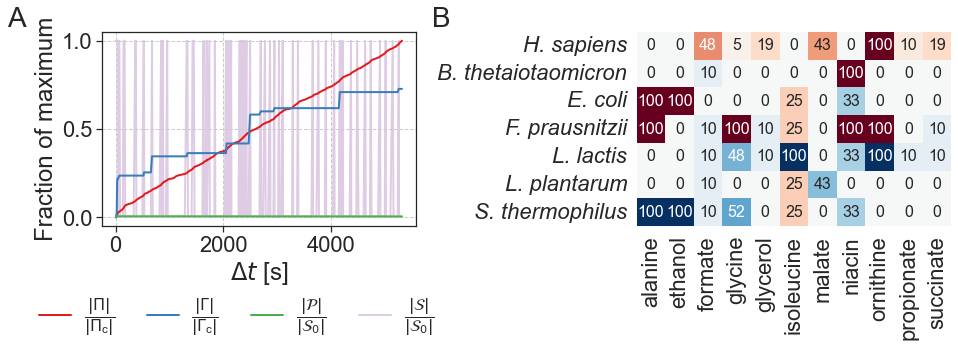

In [113]:
sns.set(style='ticks', font_scale=2)
f = plt.figure()

plt.subplot(1, 2, 1)

df = log_df

label_x = -0.5
label_y = 1.025
label_size = 28

ax = sns.lineplot(x=df.t, y=df.mps / len(mps), color='#e41a1c', label='$\\dfrac{|\Pi|}{|\Pi_\mathregular{c}|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.mcs / len(mcs), color='#377eb8', label='$\\dfrac{|\Gamma|}{|\Gamma_\mathregular{c}|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.mp_size / df.subset_size.max(), color='#4daf4a', label='$\\dfrac{|\mathcal{P}|}{|\mathcal{S}_0|}$', lw=2)
ax = sns.lineplot(x=df.t, y=df.subset_size / df.subset_size.max(), color='#decbe4', label='$\\dfrac{|\mathcal{S}|}{|\mathcal{S}_0|}$', zorder=0, lw=2)

ax.legend(frameon=False, ncol=4, loc=(-0.22, -0.6), fontsize=16)
# ax.legend(frameon=True, ncol=2, loc=(0.5, 0.07), fontsize=16)
ax.text(0.6 * label_x, label_y, 'A', transform=ax.transAxes, size=label_size)
plt.xlabel('$\Delta\it{t}$ [s]')
plt.ylabel('Fraction of maximum')
# plt.xlim(-100, 2000)
plt.grid(True, ls='--')

sns.set(font_scale=2)
plt.subplot(1, 2, 2)

ax = sns.heatmap(mat_df.T / len(mps), cmap='RdBu', annot=False, fmt='.1f', annot_kws=dict(size=16), cbar=False)
sns.heatmap((mat_df.T / len(mps)).abs() * 100, cmap='RdBu', xticklabels=1, center=0, annot=True, fmt='.0f', annot_kws=dict(size=16), cbar=False, ax=ax, alpha=0)
ax.text(label_x - 0.15, label_y, 'B', transform=ax.transAxes, size=label_size)
yticklabels = []
for x in ax.get_yticklabels():
    o = organisms[x.get_text()] 
    yticklabels.append(o[0] + '. ' + o.split(' ')[1])
# yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, rotation=0, style='italic')
# ax.set_xticks(np.arange(0.5, len(mets), 1))
ax.set_xticklabels([mets[x] for x in mat_df.index])


f.set_size_inches(14, 7)
plt.tight_layout()
plt.subplots_adjust(wspace=0.7)
# f.savefig(join(results_dir, 'fig6.pdf'), bbox_inches='tight')

# Citations

Øyås, O., & Stelling, J. (2020). Scalable metabolic pathway analysis. bioRxiv, 2020.2007.2031.230177. https://doi.org/10.1101/2020.07.31.230177